In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

BES_data_folder = "../BES_analysis_data/"
BES_code_folder = "../BES_analysis_code/"

from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE

Using Theano backend.


In [3]:
# fulldata_withPP - all samples, no columns removed due to NAs, preprocessing for weasel answers
# procdata_withPP - light cleaning
# mostdata_withPP - imputation on reduced set, 2% least filled removed
# lessdata_withPP - imputation on reduced set (% lesast filled), but only retain 2/3 filled out data
# core_withPP - just the representative cross-section core
Treatment = "lessdata_withPP/"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)


In [4]:
fname = BES_data_folder+"cat_dictionary"+".pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )
print("cat_dictionary", len( cat_dictionary ) )

cat_dictionary 650


In [5]:
var_type    = pd.read_hdf( BES_data_folder+"var_type.hdf", "var_type" )
print("var_type",  var_type.shape )

var_type (733, 1)


In [6]:
BES_reduced = pd.read_hdf(BES_data_folder+"BES_reduced.hdf","BES_reduced")
print("BES_reduced",  BES_reduced.shape )

BES_numeric = pd.read_hdf( BES_data_folder+"BESW8numeric.hdf", "BESW8numeric" )
print("BES_numeric",  BES_numeric.shape )

BES_reduced (31409, 454)
BES_numeric (31409, 659)


In [7]:
BES_reduced_with_na = pd.read_hdf(BES_data_folder+"BES_reduced_with_na.hdf","BES_reduced_with_na")
print("BES_reduced_with_na",  BES_reduced.shape )

BES_reduced_with_na (31409, 454)


In [6]:
# # reduce to representative core
# BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
# BES_reduced = BES_reduced.loc[ BES_Panel['wt_core_W8'].notnull() , : ]
# BES_numeric = BES_numeric.loc[ BES_Panel['wt_core_W8'].notnull() , : ]

In [7]:
%%time

clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

# (svd_solver='full', n_components='mle',whiten=True)

#decomp = PCA(svd_solver='full')
#decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
 #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr
decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# ,n_components=30

X_r = decomp.fit_transform(BES_std)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


Wall time: 50.3 s


In [8]:
# SAVE decomp results
suff = str(decomp).split("(")[0]

decomp_method = suff+"/"
if not os.path.exists(BES_data_folder+Treatment+decomp_method):
    os.makedirs(BES_data_folder+Treatment+decomp_method)

fname = BES_data_folder+Treatment+decomp_method+suff+".pkl"
with open(fname, "wb") as f:
    pickle.dump( decomp, f )
    
fname = BES_data_folder+Treatment+decomp_method+suff+".hdf"
BES_decomp.to_hdf(fname,suff)

## add load/save


In [8]:
# LOAD decomp results
if False or ( 'decomp' not in globals() ):

    suff = "FactorAnalysis"
    print("Loading: ",suff)
    decomp_method = suff+"/"
    if not os.path.exists(BES_data_folder+Treatment+decomp_method):
        os.makedirs(BES_data_folder+Treatment+decomp_method)

    fname = BES_data_folder+Treatment+decomp_method+suff+".pkl"
    with open(fname, "rb") as f:
        decomp = pickle.load(f) 

    fname = BES_data_folder+Treatment+decomp_method+suff+".hdf"
    BES_decomp = pd.read_hdf(fname)

    n_components = decomp.components_.shape[0]

Loading:  FactorAnalysis


In [9]:
figsz = (3,3)

if hasattr(decomp, 'explained_variance_ratio_'):
    print('explained variance ratio (first 30): %s'
          % str(decomp.explained_variance_ratio_[0:30]) )
    
if hasattr(decomp, 'explained_variance_'):
    print('explained variance (first 30): %s'
          % str(decomp.explained_variance_[0:30]) )
    plt.figure(figsize = figsz)
    plt.plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_') 
    
if hasattr(decomp, 'noise_variance_'): 
    if isinstance(decomp.noise_variance_, float):
        print('noise variance: %s'
              % str(decomp.noise_variance_) )
    
if hasattr(decomp, 'score'):
    print('average log-likelihood of all samples: %s'
          % str(decomp.score(BES_std)) )
    
if hasattr(decomp, 'score_samples') and not np.isinf( decomp.score(BES_std) ):
    pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz)

if hasattr(decomp, 'n_iter_'):
    print('number of iterations: %s'
          % str(decomp.n_iter_) )
    
if hasattr(decomp, 'loglike_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.loglike_, linewidth=2 )
    plt.xlabel('n_iter')
    plt.ylabel('log likelihood') 

if hasattr(decomp, 'error_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.error_, linewidth=2)
    plt.xlabel('n_iter')
    plt.ylabel('error') 

NameError: name 'BES_std' is not defined

In [304]:
# 0.07954041   0.03892755   0.03553862   0.01885494    0.01562524  
# 50.4286187   24.68006591  22.53148776  11.95403344   9.90639926

In [10]:
decomp

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='lapack',
        tol=0.01)

Wall time: 14.2 s


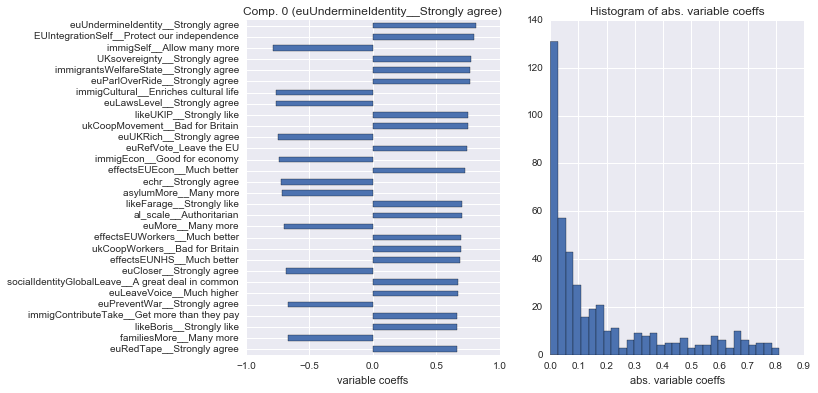

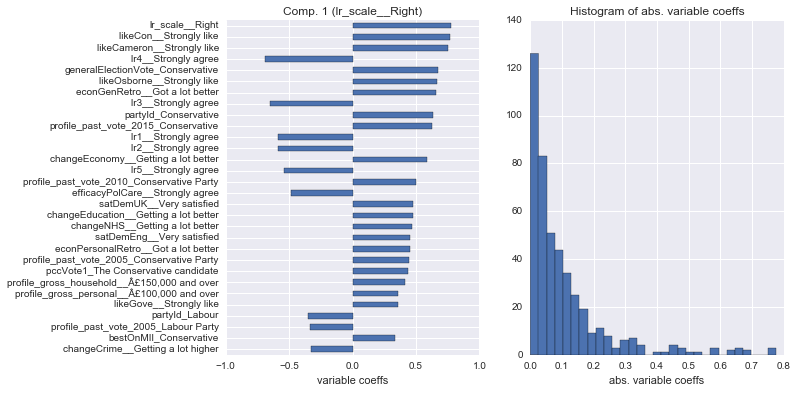

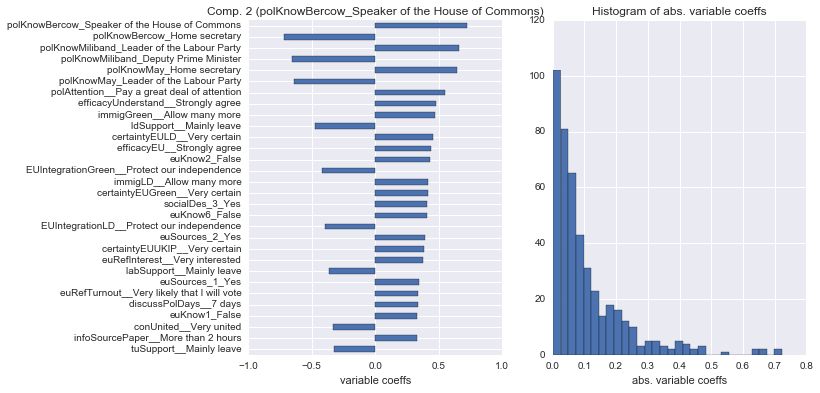

In [254]:
%%time

graph_type = "decomposition_axes/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

n_comps = min(n_components,20)
comp_labels = {}

for comp_no in range(0,n_comps):

    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[1]
    comp = pd.DataFrame( decomp.components_[comp_no], index = BES_reduced.columns, columns = ["components_"] )
    comp["comp_absmag"] = comp["components_"].abs()
    comp = comp.sort_values(by="comp_absmag",ascending=True)
    ax.set_xlabel("abs. variable coeffs")
    ax.set_title("Histogram of abs. variable coeffs")
    comp["comp_absmag"].hist( bins=30, ax=ax, figsize=(10,6) )

    # set top abs_mag variable to label
    comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
    # if top abs_mag variable is negative
    if comp[-1:]["components_"].values[0] < 0:
        comp["components_"]         = -comp["components_"]
        decomp.components_[comp_no] = -decomp.components_[comp_no]
        BES_decomp[comp_no]         = -BES_decomp[comp_no]

    ax = axes[0]
    title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
    comp_labels[comp_no] = title
    ax.set_title( title )
    ax.set_xlabel("variable coeffs")
    xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
    comp["components_"].tail(30).plot( kind='barh', ax=ax,figsize=(10,6), xlim=xlim )

    fname = folder + title.replace("/","_") +".png"
    fig.savefig( fname, bbox_inches='tight' )
    
    if comp_no >2:
        plt.close()

In [255]:
x_axis = 0
y_axis = 1

xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )

if suff == 'SparsePCA':
    xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
    ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max() 

In [278]:
BES_decomp.index
BES_reduced.loc[BES_decomp.index,decomp_label_col].shape

(20404,)

In [335]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'lr_scale__Right'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

In [334]:
# # for ordinal categorical
# # winter, autumn
# cmap_name = "winter"
# decomp_label_col = 'al_scale__Authoritarian'
# label_stub = decomp_label_col.split("__")[0]

# fig = plt.figure( figsize=(16,10) )
# plt.scatter(BES_decomp.loc[ :, x_axis ],
#             BES_decomp.loc[ :, y_axis ],
#             cmap = plt.get_cmap(cmap_name),
#             c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
#             edgecolor = "None",
#             alpha = 0.9) #            edgecolors=col,

# plt.xlim(xlim)
# plt.ylim(ylim)

# cats = cat_dictionary[ label_stub ]
# labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
# plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
# plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
# plt.xlabel( comp_labels[x_axis] )
# plt.ylabel( comp_labels[y_axis] ) 
# plt.show()

# fig.savefig( BES_data_folder+Treatment+decomp_method+label_stub+".png", bbox_inches='tight' )

noise_variance_
lr_scale__Right                                            0.094730
al_scale__Authoritarian                                    0.108017
likeCon__Strongly like                                     0.162192
polKnowBercow_Speaker of the House of Commons              0.184296
likeUKIP__Strongly like                                    0.184666
polKnowBercow_Home secretary                               0.184743
polKnowMiliband_Deputy Prime Minister                      0.199799
polKnowMiliband_Leader of the Labour Party                 0.200236
country_England                                            0.202348
likeCameron__Strongly like                                 0.207107
polKnowMay_Leader of the Labour Party                      0.210975
polKnowMay_Home secretary                                  0.211019
immigSelf__Allow many more                                 0.215646
likeFarage__Strongly like                                  0.221656
countryOfBirth_England                                     0.222317
edlevel__Postgrad                                          0.231213
likeLab__Strongly like                                     0.233346
immigEcon__Good for economy                                0.242161
generalElectionVote_Conservative                           0.243894
prevJob_Yes, I have done paid work in the past             0.244066
EUIntegrationSelf__Protect our independence                0.247041
effectsEUEcon__Much better                                 0.249192
gor_Scotland                                               0.255904
partyId_Conservative                                       0.261746
selfOccStatusLast_An employee                              0.262877
euUndermineIdentity__Strongly agree                        0.264804
immigCultural__Enriches cultural life                      0.265198
immigrantsWelfareState__Strongly agree                     0.266203
likeCorbyn__Strongly like                                  0.267106
euMore__Many more                                          0.267440
...                                                             ...
housing_Own (part-own) through shared ownership...         0.867675
education_Teaching qualification (not degree)              0.867686
euMIISmall_Campaign/outcome fairness                       0.869733
profile_newspaper_readership_201_The Express               0.870310
euMIISmall_No content to reason                            0.871515
profile_religion_Yes - Free Presbyterian                   0.872508
education_Recognised trade apprenticeship compl...         0.873170
profile_ethnicity_White and Asian                          0.873252
profile_ethnicity_Any other Asian background               0.875367
education_Nursing qualification (eg SEN, SRN, S...         0.877360
profile_past_vote_2015_British National Party (...         0.877697
euRefFinal_There might be a second referendum              0.878150
profile_ethnicity_Any other mixed background               0.879072
euGovtLeaflet_Yes, received but not read it                0.880356
profile_newspaper_readership_201_The Scotsman              0.882389
profile_newspaper_readership_201_The Daily Star...         0.882404
profile_ethnicity_White and Black African                  0.884019
education_Youth training certificate/skillseekers          0.887042
marital_Civil Partnership                                  0.889128
education_onc                                              0.896325
euMIISmall_EU spending/regulations/cost                    0.897896
bestOnMII_Other party                                      0.898085
euMIISmall_Social identity/partisanship                    0.899165
profile_newspaper_readership_201_The Financial ...         0.900895
countryOfBirth_Northern Ireland                            0.901279
euMIISmall_Other stability or uncertainty concern          0.907835
profile_ethnicity_Any other black background               0.917168
euMIISmall_Family                       

noise_variance_
countryOfBirth_Northern Ireland                            0.901279
euMIISmall_EU integration/stability                        0.921800
euMIISmall_Family                                          0.921229
euMIISmall_Other stability or uncertainty concern          0.907835
profile_ethnicity_Any other black background               0.917168
profile_newspaper_readership_201_The Financial ...         0.900895
profile_past_vote_2005_Veritas                             0.928330

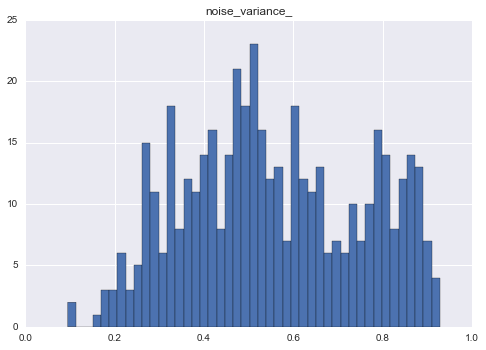

In [282]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [311]:
# # who are the "improbables"?

# if hasattr(decomp, 'score_samples'):
#     most_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.999).values[0]
#     least_likely = pd.DataFrame(decomp.score_samples(BES_std)).quantile(.001).values[0]
#     print("least likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)<least_likely] ])
# # who are the "stereotypes"?
#     print("most likely")
#     display(BES_num_and_cat.loc[ BES_reduced.index[decomp.score_samples(BES_std)>most_likely ] ])
# # check to see balance of missing values!

number of estimated clusters : 46


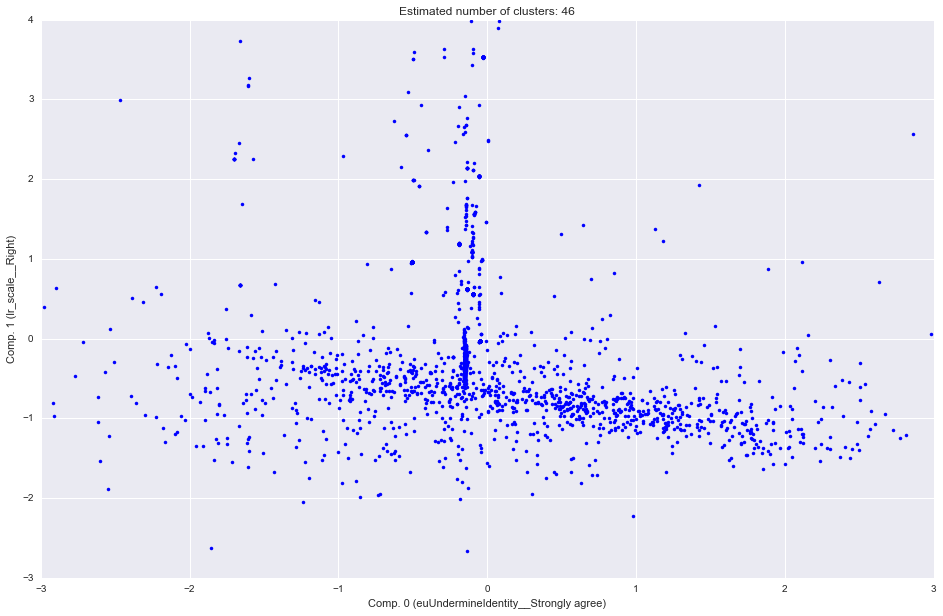

In [283]:
# %%time
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

X = X_r

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)


fig = plt.figure( figsize=(16,10) )
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, x_axis], X[my_members, y_axis], col + '.')
    plt.plot(cluster_center[x_axis], cluster_center[y_axis], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Estimated number of clusters: %d' % n_clusters_)
# plt.show()

fig.savefig(BES_data_folder+Treatment+decomp_method+"Cluster_estimation.png",bbox_inches='tight')


In [284]:
colours = cycle('ycmkgbr')
markers = cycle('v^<>,oD*x+')

cat_col_mar_dict = {} # category-colour-marker dictionary
# basic set of common ones! 
cat_col_mar_dict['Conservative'] = ('b', '.')
cat_col_mar_dict['Conservative Party'] = ('b', '.')
cat_col_mar_dict['The Conservative candidate']       = ('b', '.')
cat_col_mar_dict['Labour']       = ('r', '.')
cat_col_mar_dict['Labour Party']       = ('r', '.')
cat_col_mar_dict['The Labour candidate']       = ('r', '.')
cat_col_mar_dict['Green Party']  = ('g', '.')
cat_col_mar_dict['The Green candidate']       = ('g', '.')
cat_col_mar_dict['Plaid Cymru']  = ('k', '.')
cat_col_mar_dict['The Plaid Cymru candidate']  = ('k', '.')
cat_col_mar_dict['Scottish National Party']           = ('c', '.')
cat_col_mar_dict['United Kingdom Independence Party'] = ('m', '.')
cat_col_mar_dict['The UKIP candidate'] = ('m', '.')
cat_col_mar_dict['Liberal Democrat']                         = ('orange', '.')
cat_col_mar_dict['Liberal Democrats']                        = ('orange', '.')
cat_col_mar_dict['The Liberal Democrat candidate']                         = ('orange', '.')

In [333]:
# BES_reduced.columns

In [330]:
# BES_Panel["riskScale"]

In [331]:
# [ x for x in BES_reduced.columns if re.match(decomp_label_col + "(__)?", x) ]

# # re.match(decomp_label_col + "__", )

In [332]:
# dummy_list

C:\ANACON~1\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Exception: len(decomp_label_categories) > 1 !!!

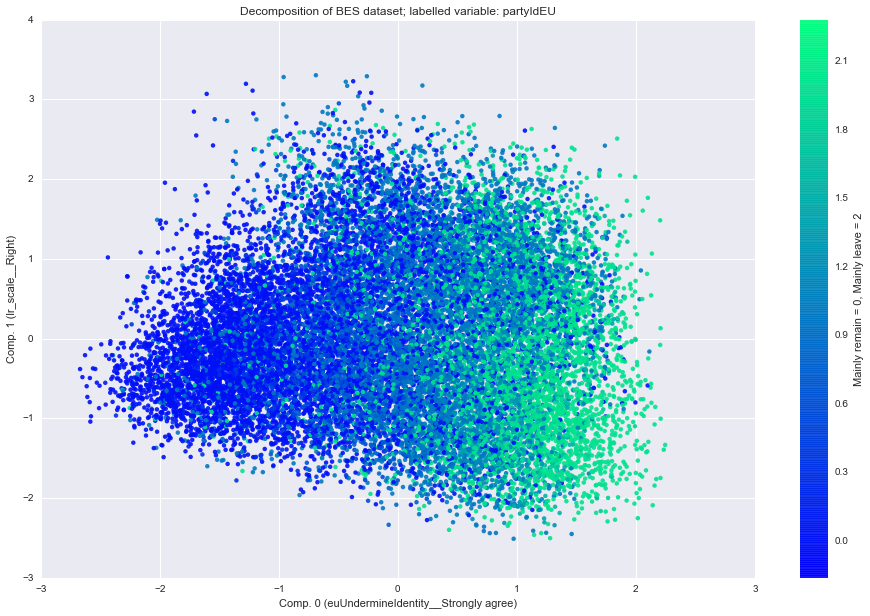

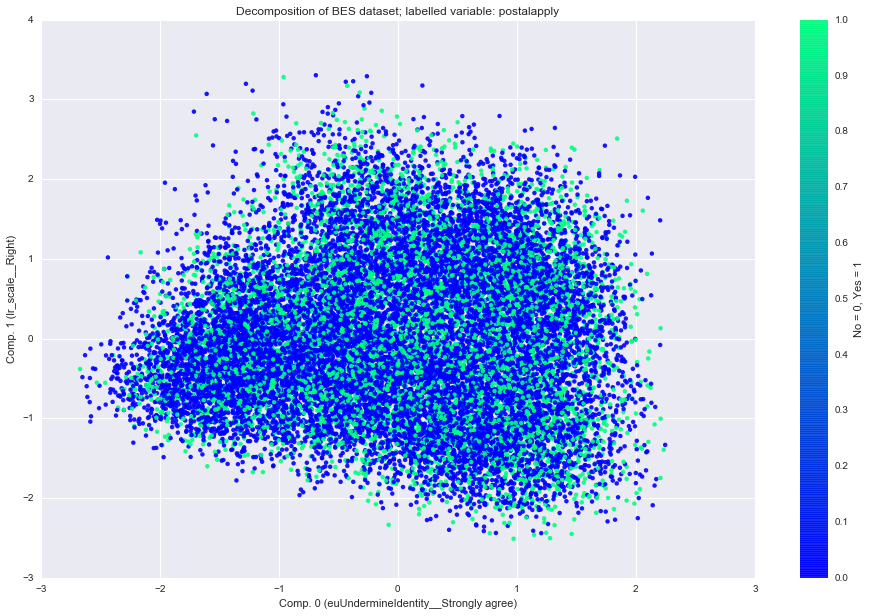

In [336]:
%%time

graph_type = "ordinal_scatter/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)
    

dummy_list = var_type[ [ x in [ 0, 1, 2, 5, 6 ] for x in var_type["type"]  ] ].index # 0, 1, 2, 5, 6.index # ordinal variables

# ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
#     if decomp_label_col in ["profile_religion","country",
#                             'polKnowMay','polKnowOsborne',
#                             'polKnowClegg', 'polKnowBercow',
#                             'polKnowMiliband', 'registered', 'ns_sec']:
#         continue
    
    fig = plt.figure( figsize=(16,10) )

    # go through all the variables that have been created from base variables through transformation
    # for ordinal variables, these should only ever be unique matches (unlike non-ordinals)
    decomp_label_categories = [ x for x in BES_reduced.columns if re.match(decomp_label_col + "_?_?", x) ]
    if len(decomp_label_categories) == 0: # removed during transformation/reduction
        continue
    elif len(decomp_label_categories) > 1:
        raise Exception('len(decomp_label_categories) > 1 !!!')
    # c = BES_reduced.loc[BES_decomp.index,decomp_label_col].values,
    
    label_stub = decomp_label_col

    plt.scatter(BES_decomp.loc[ :, x_axis ],
                BES_decomp.loc[ :, y_axis ],
                cmap = plt.get_cmap(cmap_name),
                c = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values,
                edgecolor = "None",
                alpha = 0.9) #            edgecolors=col,

    plt.xlim(xlim)
    plt.ylim(ylim)

    # get category labels for categorical variables
    if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
        cats = cat_dictionary[ label_stub ]
        labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
    elif var_type.loc[label_stub,"type"] in [ 0 ]:
        vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values
        labels = ( "min val", min(vals), "max val", max(vals) )
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')
        
    plt.colorbar().set_label('{} = {}, {} = {}'.format(*labels))
    plt.title( 'Decomposition of BES dataset; labelled variable: ' + decomp_label_col )
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
#     plt.show()
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1
#     print(fig_no)

C:\ANACON~1\envs\BES_analysis\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Wall time: 25.2 s


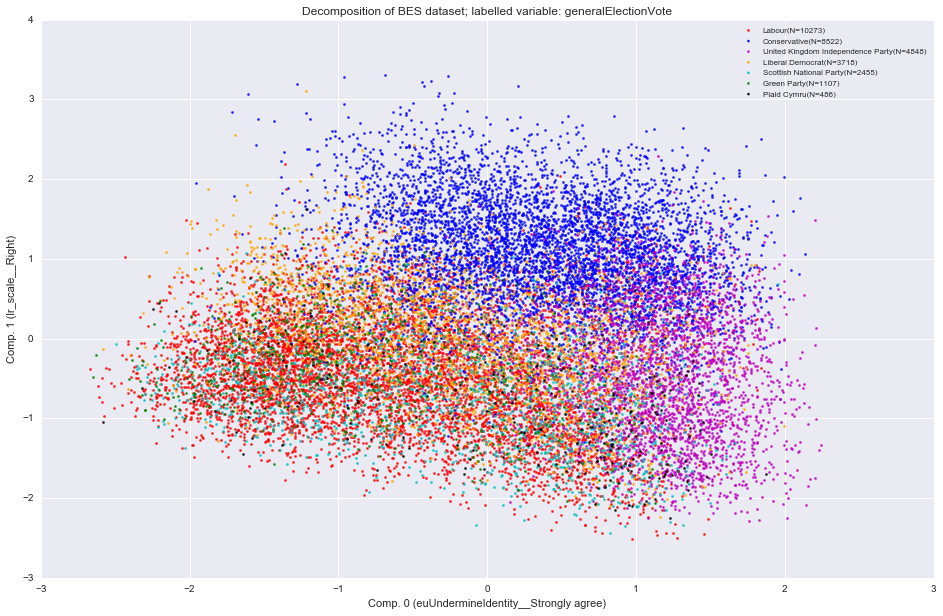

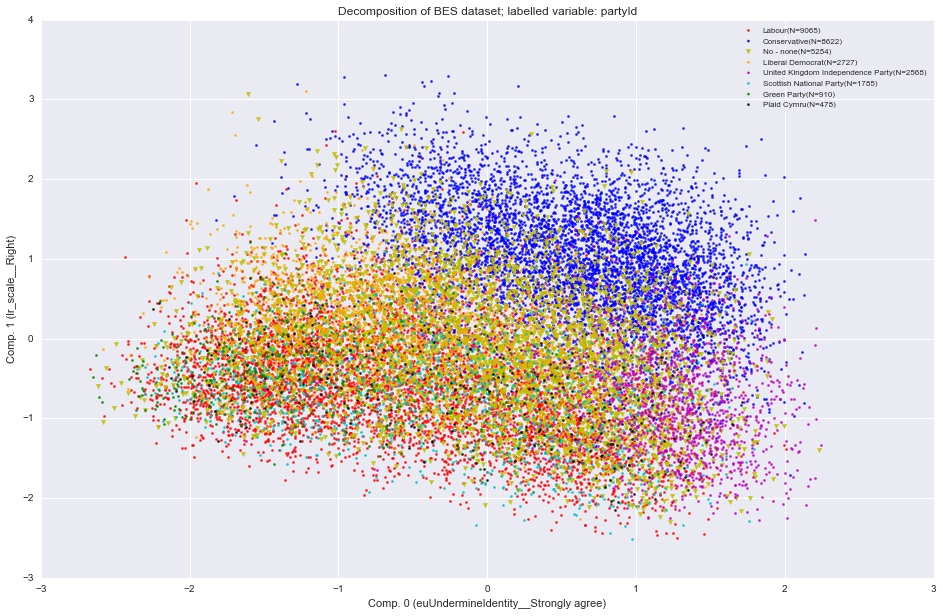

In [337]:
%%time

graph_type = "non_ordinal_scatter/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered', 'ns_sec']:
        continue
    
    fig = plt.figure( figsize=(16,10) )

    decomp_label_categories = [ x for x in BES_reduced.columns if (decomp_label_col + "_") in x ]
    if len(decomp_label_categories) == 0:
        continue

    # 'No party is best able to handle this issue'
    drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
    for drop_cat in drop_cat_list:
        if drop_cat in decomp_label_categories:
            decomp_label_categories.remove(drop_cat)
            
    replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                    'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

    lab_to_cat = {}
    sample_sizes = {}
    for cat in decomp_label_categories:
        
        lab = re.search('_([^_]+)$',cat).groups()[0]
        if lab in replace_dict.keys(): # replace party name variants with single version
            lab = replace_dict[lab]
        
        if lab not in cat_col_mar_dict.keys(): # try to give parties consistent colour, marker pairs
            cat_col_mar_dict[lab] = (next(colours),next(markers))
        
        sample_sizes[lab] = sum( BES_reduced[ cat ]==1 )
        lab_to_cat[lab] = cat

    for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):
        
        samp = sample_sizes[lab]
            
        (col, mar) = cat_col_mar_dict[lab]

        cat_entries = BES_reduced[ lab_to_cat[lab] ]==1
        
        plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                    BES_decomp.loc[ cat_entries, y_axis ],
                    c= col,
                    marker=mar,
                    label=lab + "(N="+str(samp)+")",
                    edgecolors=col,
                    alpha = .9 )
    
    plt.xlim(xlim)
    plt.ylim(ylim)    
    
    plt.xlabel( comp_labels[x_axis] )
    plt.ylabel( comp_labels[y_axis] ) 
    plt.legend(prop={'size':8})
    plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)
    
    fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

In [350]:
col

'riskScale'

In [351]:
var_type.loc[col,"type"]

0

In [338]:
# col = "euRefVote"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# # add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# # make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
# g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

# # plt.xlim(xlim)
# # plt.ylim(ylim)   
# # plt.xlim(-3, 3)  
# # plt.ylim(-3, 3)

# # labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')

# # save to file
# g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')

In [368]:
BES_numeric['riskScale'].astype('category')
df[col].value_counts()
[str(x) for x in df[col].cat.categories]
df[col].value_counts().values

array([3166, 3080, 2319, 2212, 1992, 1765, 1575, 1312, 1290,  496,  289,
        262,  217,  195,  144,   90], dtype=int64)

Wall time: 2min 11s


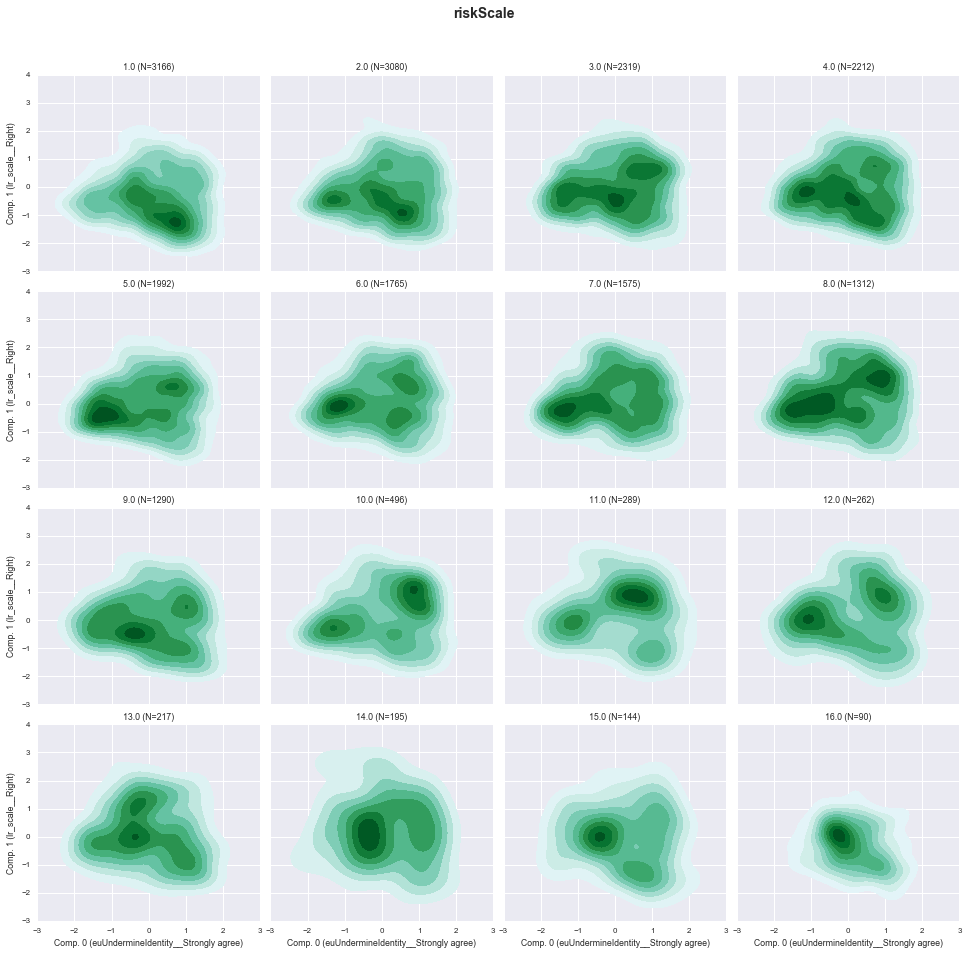

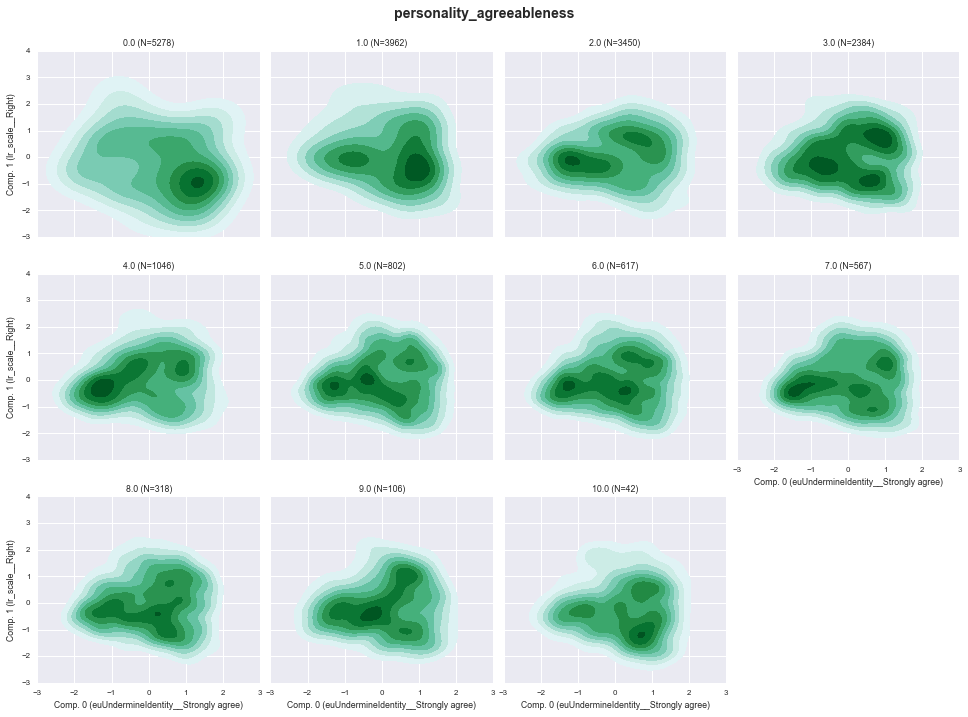

In [371]:
%%time

graph_type = "ordinal_kde/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ [ x in [ 0 ] for x in var_type["type"]  ] ].index # , 1, 2, 5, 6

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

#     # get category labels for categorical variables
#     if var_type.loc[label_stub,"type"] in [ 1, 2, 5, 6 ]:
#         cats = cat_dictionary[ label_stub ]
#         labels = ( cats[0], str(0), cats[-1], str(len( cats ) - 1) )
#     elif var_type.loc[label_stub,"type"] in [ 0 ]:
#         vals = BES_reduced.loc[ BES_decomp.index , decomp_label_categories[0] ].values
#         labels = ( "min val", min(vals), "max val", max(vals) )
#     else:
#         raise Exception('var_type not in [ 0, 1, 2, 5, 6]')    
    
    if var_type.loc[col,"type"] in [ 1, 2, 5, 6 ]:
    
        # reduce length of subcategories
        cats = list(cat_dictionary[col])
        for catno in range( len( cats ) ):

            words = cats[catno].split(" ")
            word_array = np.array( [len(x) for x in words] ) + 1
            max_words = np.where( np.cumsum( word_array )<30 )[0].max()
            cats[catno] = " ".join( words[0:max_words+1] )
        # NOTE - can cause problems if 2+ truncated subcategories are identical

        # add a category column to split the graphs on
        df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().loc[cats].values        
    elif var_type.loc[col,"type"] in [ 0 ]:
        df[col] = BES_numeric[col].astype('category')
        cats = [str(x) for x in df[col].cat.categories]
        # add N=??? sample size to each category type!
        sample_sizes = df[col].value_counts().values          
    else:
        raise Exception('var_type not in [ 0, 1, 2, 5, 6]')          
        

    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(folder+col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

Wall time: 8min 46s


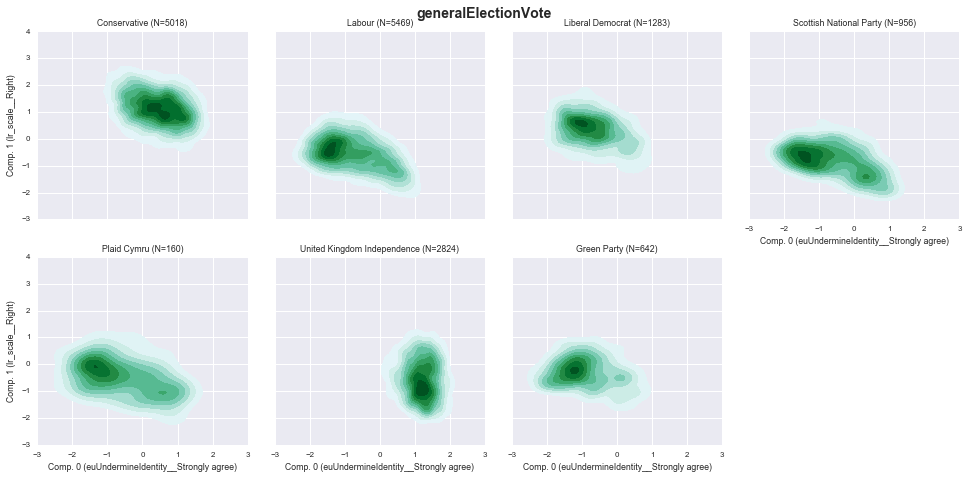

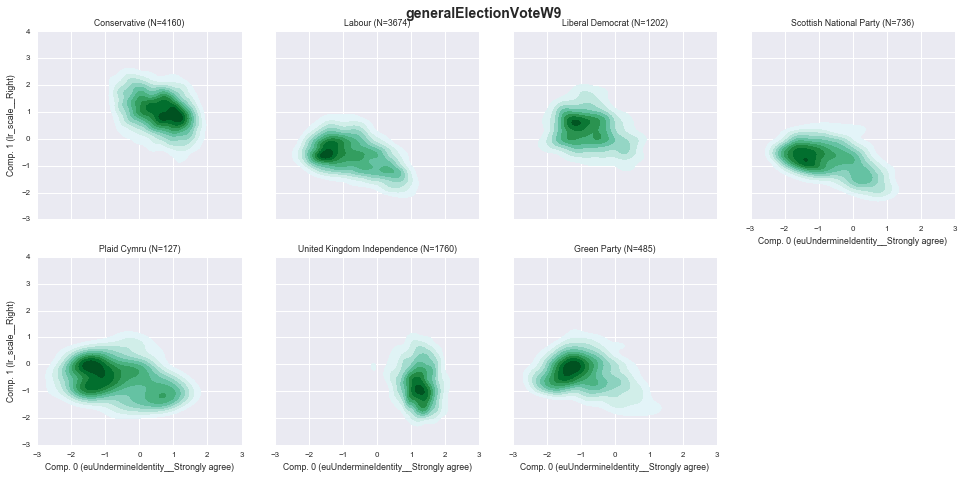

In [372]:
%%time

graph_type = "non_ordinal_kde/"
folder = BES_data_folder+Treatment+decomp_method+graph_type
if not os.path.exists(folder):
    os.makedirs(folder)

dummy_list = var_type[ var_type["type"]==3 ].index

sns.set(font_scale=.8)

# non-ordinal categories
fig_no = 0
for decomp_label_col in dummy_list:
    if decomp_label_col in ["profile_religion","country",
                            'polKnowMay','polKnowOsborne',
                            'polKnowClegg', 'polKnowBercow',
                            'polKnowMiliband', 'registered',
                            'country_of_residence1','country_of_residence2',
                           'polKnowMiliband', 'polKnowClegg',
       'polKnowOsborne', 'polKnowMay', 'polKnowBercow',
'polKnowKerryW9',
       'polKnowHollandeW9', 'polKnowNetanyahuW9', 'polKnowPutinW9',
       'polKnowMerkelW9', 'polKnowAssadW9', 
       'ns_sec', 'EUMIICategory', 'age', 'Age', 'euRefExpectation',
       'country_of_residence2', 'country_of_residence1', 'profile_lea',
       'profile_oslaua', 'pano',
                           'EUMIICategory']:
        continue
    
#     col = "euRefVote"
#     fig = plt.figure( figsize=(16,10) )
    col = decomp_label_col

    df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
    max_cols = 4

    # reduce length of subcategories
    cats = list(cat_dictionary[col])
    for catno in range( len( cats ) ):

        words = cats[catno].split(" ")
        word_array = np.array( [len(x) for x in words] ) + 1
        max_words = np.where( np.cumsum( word_array )<30 )[0].max()
        cats[catno] = " ".join( words[0:max_words+1] )
    # NOTE - can cause problems if 2+ truncated subcategories are identical

    # add a category column to split the graphs on
    df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

    # add N=??? sample size to each category type!
    sample_sizes = df[col].value_counts().loc[cats].values
    cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
    df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

    # formatting
    n_cols = len(df[col].dropna().unique())
    n_rows = np.ceil(n_cols/max_cols)
    col_wrap = min(max_cols,n_cols)
    size = 13.5/col_wrap

    # make the actual graphs
    g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
    g.map(sns.kdeplot, x_axis, y_axis, shade=True, shade_lowest=False).set_titles("{col_name}")

    plt.xlim(xlim)
    plt.ylim(ylim)   
    # plt.xlim(-3, 3)  
    # plt.ylim(-3, 3)

    # labels and title
    plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
    g.set_xlabels( comp_labels[x_axis] )
    g.set_ylabels( comp_labels[y_axis] ) 
    g.fig.suptitle(col, fontsize=14, fontweight='bold')

    # save to file
    g.savefig(BES_data_folder+Treatment+decomp_method+col+"_kde", bbox_inches='tight')
    if fig_no >1:
        plt.close()
    fig_no = fig_no + 1

Wall time: 14.3 s


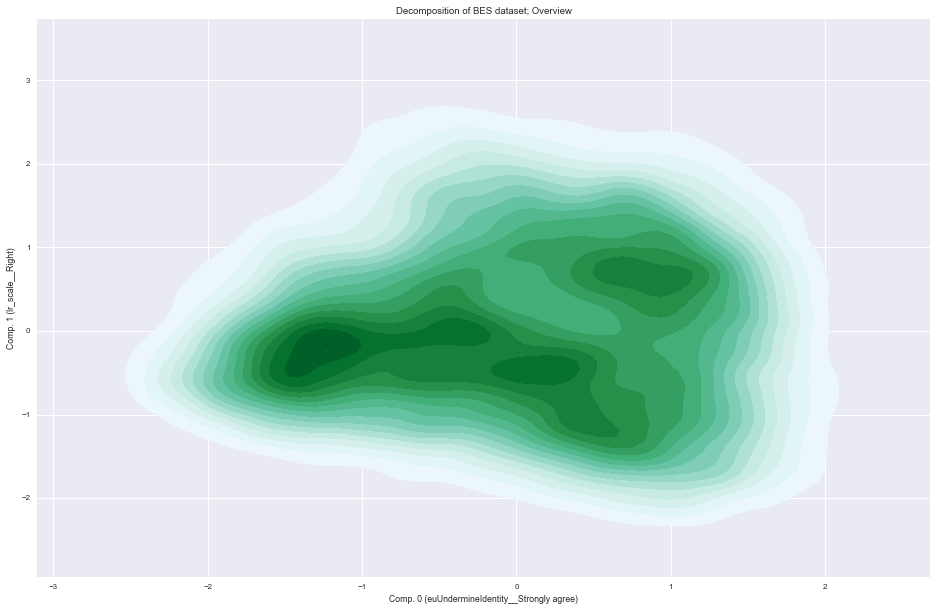

In [37]:
%%time
# col = "edlevel"

# df = BES_decomp.loc[ : , [x_axis,y_axis] ].copy()
# max_cols = 4

# # reduce length of subcategories
# cats = list(cat_dictionary[col])
# for catno in range( len( cats ) ):

#     words = cats[catno].split(" ")
#     word_array = np.array( [len(x) for x in words] ) + 1
#     max_words = np.where( np.cumsum( word_array )<25 )[0].max()
#     cats[catno] = " ".join( words[0:max_words+1] )


# add a category column to split the graphs on
# df[col] = BES_numeric[col].astype('category').cat.rename_categories( cats )

# # add N=??? sample size to each category type!
# sample_sizes = df[col].value_counts().loc[cats].values
# cat_plus_sample_sizes = ["".join([x," (N=", str(y),")"]) for x,y in zip(cats, sample_sizes)]
# df[col].cat.rename_categories( cat_plus_sample_sizes, inplace=True )

# # formatting
# n_cols = len(df[col].dropna().unique())
# n_rows = np.ceil(n_cols/max_cols)
# col_wrap = min(max_cols,n_cols)
# size = 13.5/col_wrap

# make the actual graphs
# g = sns.FacetGrid(df, col=col,size=size,col_wrap=col_wrap)  
fig = plt.figure( figsize=(16,10) )
sns.kdeplot(BES_decomp.loc[ : , [x_axis,y_axis] ],
            shade=True, shade_lowest=False, n_levels=20) #, shade=True, shade_lowest=False)
# g.set_titles("{col_name}")

# plt.xlim(xlim)
# plt.ylim(ylim)   
# plt.xlim(-3, 3)  
# plt.ylim(-3, 3)

# labels and title
# plt.subplots_adjust( top = 1-( .05 + .01*n_rows ) )
# g.set_xlabels( comp_labels[x_axis] )
# g.set_ylabels( comp_labels[y_axis] ) 
# g.fig.suptitle(col, fontsize=14, fontweight='bold')
plt.xlabel( comp_labels[x_axis] )
plt.ylabel( comp_labels[y_axis] ) 
plt.title('Decomposition of BES dataset; Overview')
# save to file
fig.savefig(BES_data_folder+Treatment+decomp_method+"overview"+"_kde", bbox_inches='tight')

In [9]:
%%time
# Load BES Panel for Wave 8
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta") # 130Mb
#(31409, 733)

# BES_Panel = pd.read_stata(BES_data_folder+BES2015_W8_v1.6.dta")

print( BES_Panel.shape )

(31409, 733)
Wall time: 14.7 s


In [15]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
weights = BES_Panel['wt_full_W8']
print(weights.shape)

samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
samples = np.swapaxes(samples,0,1)
print(samples.shape)

(2, 31409)

In [16]:
#create mesh grid
x = np.linspace(xlim[0], xlim[1], 100)
y = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(x, y)

In [18]:
#Evaluate the kde on a grid
pdf = gaussian_kde(samples.values, weights=weights.values)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)

In [17]:
gc.collect()

7

In [19]:
kwargs = dict(extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='hot', origin='lower')

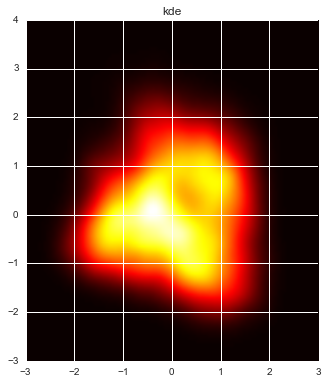

In [21]:
plt.figure()
plt.imshow(zz, **kwargs)
plt.title('kde')
plt.tight_layout()
plt.show()

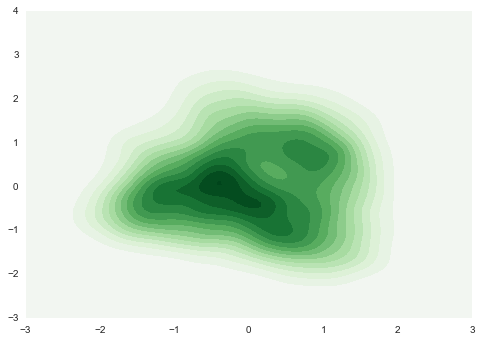

In [35]:
from matplotlib import mlab, cm
levels = np.arange(0, 0.16, 0.01)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=abs(zz).max(), vmin=-abs(zz).max())
cmap = cm.PRGn
cset1 = plt.contourf(xx, yy, zz, levels,
                 cmap=cm.get_cmap(cmap, len(levels) - 1),
                 norm=norm,
                 )

In [28]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
weights = BES_Panel['wt_core_W8'].dropna()
print(weights.shape)




# samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
samples = np.swapaxes(samples,0,1)
print(samples.shape)

(20404,)
(2, 20404)


In [31]:
# %%time
#create mesh grid
x = np.linspace(xlim[0], xlim[1], 100)
y = np.linspace(ylim[0], ylim[1], 100)
xx, yy = np.meshgrid(x, y)

#Evaluate the kde on a grid
pdf = gaussian_kde(samples.values, weights=weights.values)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)



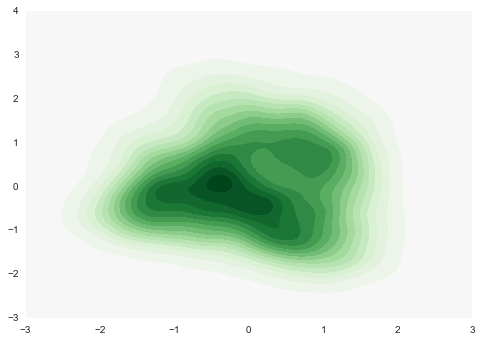

In [32]:
from matplotlib import mlab, cm
vmax=abs(zz).max()
vmin=-abs(zz).max()
levels = np.arange(vmin*1.1, vmax*1.1, (vmax-vmin)/30)  # Boost the upper limit to avoid truncation errors.
norm = cm.colors.Normalize(vmax=vmax, vmin=vmin)
cmap = cm.PRGn
cset1 = plt.contourf(xx, yy, zz, levels,
                 cmap=cm.get_cmap(cmap, len(levels) - 1),
                 norm=norm,
                 )

In [30]:
gc.collect()

0

In [14]:
# From here!
# http://nbviewer.jupyter.org/gist/tillahoffmann/f844bce2ec264c1c8cb5

import numpy as np
from scipy.spatial.distance import cdist

class gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import seaborn; seaborn.set() # set plot style

# https://github.com/jakevdp/wpca
# https://github.com/jakevdp/wpca/blob/master/WPCA-Example.ipynb
from wpca import PCA, WPCA, EMPCA

In [11]:
BES_Panel = pd.read_stata(BES_data_folder+"BES2015_W8_v1.3.dta")
# weights = BES_Panel['wt_full_W8']
row_weights = BES_Panel['wt_full_W8'].dropna()
print(row_weights.shape)

# # samples = BES_decomp.loc[ : , [x_axis,y_axis] ]
# samples = BES_decomp.loc[ BES_Panel['wt_core_W8'].notnull() , [x_axis,y_axis] ]
# samples = np.swapaxes(samples,0,1)
# print(samples.shape)

(31409,)


In [125]:
# thresh = .2
# counts = BES_numeric.count()
# mostly_not_filled_out = counts[counts<= (counts.max()*thresh)].index
# # mostly_filled_out     = counts[counts>  (counts.max()*thresh)].index
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])

# many_cat_drop_list = ['Age', 'EUMIICategory', 'age', 'country_of_residence1',
#        'country_of_residence2', 'euRefExpectation', 'ns_sec', 'pano',
#        'profile_lea', 'profile_oslaua']

# high_corr_drop_list = ['ageGroup', 'euRefVote2', 'euRefVotePost', 'euRefVoteUnsqueeze',
#        'recallVote15', 'voted2015']

# very_low_var = ['partyContactLD_6', 'partyContactLD_7', 'partyContactUKIP_1']

# BES_reduced = BES_numeric.copy()
# BES_reduced.drop(W9_vars,               axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(mostly_not_filled_out, axis=1, inplace=True, errors='ignore')
# # BES_reduced.drop(many_cat_drop_list   , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(high_corr_drop_list  , axis=1, inplace=True, errors='ignore')
# BES_reduced.drop(very_low_var         , axis=1, inplace=True, errors='ignore')
# print(BES_reduced.shape)

(31409, 265)


In [211]:
BES_reduced_with_na.shape

(31409, 454)

In [212]:
# BES_reduced = BES_reduced_with_na[BES_reduced_with_na.columns[0:200]][0:30000].copy()
BES_reduced = BES_reduced_with_na.copy()

In [213]:
weights = BES_reduced.notnull().astype('int').apply(lambda x: x*row_weights)

In [214]:
clean_feature_set_std = StandardScaler().fit_transform(BES_reduced.fillna(0).values )

In [215]:
# "weightPCAreduced_withPP/" - 2% reduced data
Treatment = "weightPCAreduced_withPP/"
if not os.path.exists(BES_data_folder+Treatment):
    os.makedirs(BES_data_folder+Treatment)

In [216]:
%%time
from wpca import PCA, WPCA, EMPCA

BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = BES_reduced.columns,
                             index   = BES_reduced.index      )

# decomp = PCA(svd_solver='full')
# #decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#  #    n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# # decomp = SparsePCA(n_components=30, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
# #
# # alpha=2 -> 1hr
# decomp = FactorAnalysis(svd_method = 'lapack') ## ~10s ,n_components=30 -> 1.5 hrs
# # ,n_components=30
# PCA, WPCA, EMPCA
# decomp = PCA(n_components=10)
# decomp = EMPCA() # overnight!
decomp = WPCA() # 21 minutes, 7min 54s
decomp = WPCA(n_components=10) # 6.2s
decomp = EMPCA(n_components=10) # 6.2s
decomp = EMPCA()
# decomp = EWPCA(n_components=10)
# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0:
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_reduced.index)


KeyboardInterrupt: 

In [ ]:
suff = str(decomp).split("(")[0]

decomp_method = suff+"/"
if not os.path.exists(BES_data_folder+Treatment+decomp_method):
    os.makedirs(BES_data_folder+Treatment+decomp_method)

In [ ]:
figsz = (3,3)

if hasattr(decomp, 'explained_variance_ratio_'):
    print('explained variance ratio (first 30): %s'
          % str(decomp.explained_variance_ratio_[0:30]) )
    
if hasattr(decomp, 'explained_variance_'):
    print('explained variance (first 30): %s'
          % str(decomp.explained_variance_[0:30]) )
    plt.figure(figsize = figsz)
    plt.plot( range(1,n_components+1), decomp.explained_variance_, linewidth=2)
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_') 
    
if hasattr(decomp, 'noise_variance_'): 
    if isinstance(decomp.noise_variance_, float):
        print('noise variance: %s'
              % str(decomp.noise_variance_) )
    
if hasattr(decomp, 'score'):
    print('average log-likelihood of all samples: %s'
          % str(decomp.score(BES_std)) )
    
if hasattr(decomp, 'score_samples') and not np.isinf( decomp.score(BES_std) ):
    pd.DataFrame( decomp.score_samples(BES_std) ).hist(bins=100,figsize = figsz)

if hasattr(decomp, 'n_iter_'):
    print('number of iterations: %s'
          % str(decomp.n_iter_) )
    
if hasattr(decomp, 'loglike_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.loglike_, linewidth=2 )
    plt.xlabel('n_iter')
    plt.ylabel('log likelihood') 

if hasattr(decomp, 'error_'):
    plt.figure(figsize = figsz)
    plt.plot( decomp.error_, linewidth=2)
    plt.xlabel('n_iter')
    plt.ylabel('error') 

In [ ]:
# %%time
n_comps = min(n_components,20)
comp_labels = {}

for comp_no in range(0,n_comps):

    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[1]
    comp = pd.DataFrame( decomp.components_[comp_no], index = BES_reduced.columns, columns = ["components_"] )
    comp["comp_absmag"] = comp["components_"].abs()
    comp = comp.sort_values(by="comp_absmag",ascending=True)
    ax.set_xlabel("abs. variable coeffs")
    ax.set_title("Histogram of abs. variable coeffs")
    comp["comp_absmag"].hist( bins=30, ax=ax, figsize=(10,6) )

    # set top abs_mag variable to label
    comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
    # if top abs_mag variable is negative
    if comp[-1:]["components_"].values[0] < 0:
        comp["components_"]         = -comp["components_"]
        decomp.components_[comp_no] = -decomp.components_[comp_no]
        BES_decomp[comp_no]         = -BES_decomp[comp_no]

    ax = axes[0]
    title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
    comp_labels[comp_no] = title
    ax.set_title( title )
    ax.set_xlabel("variable coeffs")
    xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
    comp["components_"].tail(30).plot( kind='barh', ax=ax,figsize=(10,6), xlim=xlim )

    fname = BES_data_folder + Treatment +decomp_method + title.replace("/","_") +".png"
    fig.savefig( fname, bbox_inches='tight' )
    
    if comp_no >4:
        plt.close()

In [ ]:
gc.collect()

In [ ]:
decomp

In [ ]:
# "I'd be interested to see the actual per-question differences
#  between the bottom-left and bottom-right corners of the
#  population blob - is there one of the economic-left-coded
#  questions that is particularly incompatible with social liberalism?"

In [373]:
decomp

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000, n_components=None,
        noise_variance_init=None, random_state=0, svd_method='lapack',
        tol=0.01)

In [382]:
comp = pd.DataFrame( decomp.components_[0], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["al_scale__Authoritarian"],
 comp.loc["al1__Strongly agree"],
 comp.loc["al2__Strongly agree"],
 comp.loc["al3__Strongly agree"],
 comp.loc["al4__Strongly agree"],
 comp.loc["al5__Strongly agree"] ]

[components_    0.70155
 Name: al_scale__Authoritarian, dtype: float64, components_    0.581039
 Name: al1__Strongly agree, dtype: float64, components_    0.607948
 Name: al2__Strongly agree, dtype: float64, components_    0.488536
 Name: al3__Strongly agree, dtype: float64, components_    0.359837
 Name: al4__Strongly agree, dtype: float64, components_    0.558323
 Name: al5__Strongly agree, dtype: float64]

In [391]:
comp = pd.DataFrame( decomp.components_[0], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["lr_scale__Right"],
 comp.loc["lr1__Strongly agree"],
 comp.loc["lr2__Strongly agree"],
 comp.loc["lr3__Strongly agree"],
 comp.loc["lr4__Strongly agree"],
 comp.loc["lr5__Strongly agree"] ]

[components_    0.175046
 Name: lr_scale__Right, dtype: float64, components_   -0.295558
 Name: lr1__Strongly agree, dtype: float64, components_   -0.110175
 Name: lr2__Strongly agree, dtype: float64, components_   -0.147625
 Name: lr3__Strongly agree, dtype: float64, components_   -0.100921
 Name: lr4__Strongly agree, dtype: float64, components_   -0.007249
 Name: lr5__Strongly agree, dtype: float64]

In [392]:
comp = pd.DataFrame( decomp.components_[1], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["al_scale__Authoritarian"],
 comp.loc["al1__Strongly agree"],
 comp.loc["al2__Strongly agree"],
 comp.loc["al3__Strongly agree"],
 comp.loc["al4__Strongly agree"],
 comp.loc["al5__Strongly agree"] ]

[components_   -0.106483
 Name: al_scale__Authoritarian, dtype: float64, components_   -0.091276
 Name: al1__Strongly agree, dtype: float64, components_   -0.125471
 Name: al2__Strongly agree, dtype: float64, components_    0.002722
 Name: al3__Strongly agree, dtype: float64, components_   -0.044075
 Name: al4__Strongly agree, dtype: float64, components_   -0.120942
 Name: al5__Strongly agree, dtype: float64]

In [393]:
comp = pd.DataFrame( decomp.components_[1], index = BES_reduced.columns, columns = ["components_"] )
[comp.loc["lr_scale__Right"],
 comp.loc["lr1__Strongly agree"],
 comp.loc["lr2__Strongly agree"],
 comp.loc["lr3__Strongly agree"],
 comp.loc["lr4__Strongly agree"],
 comp.loc["lr5__Strongly agree"] ]

[components_    0.775194
 Name: lr_scale__Right, dtype: float64, components_   -0.58663
 Name: lr1__Strongly agree, dtype: float64, components_   -0.586496
 Name: lr2__Strongly agree, dtype: float64, components_   -0.65536
 Name: lr3__Strongly agree, dtype: float64, components_   -0.692534
 Name: lr4__Strongly agree, dtype: float64, components_   -0.539764
 Name: lr5__Strongly agree, dtype: float64]

In [394]:
# looking at the lr/al contribution to the first two components
# significant (either top variable or close) and well behaved
# (lr_scale and al_scale make a bigger contribution than any individual question)

# Only thing that does stand out:
# in Component 0 (EUrefVote/authoritarian) axes, lr_scale and variables are basically noise ...
# ... except for lr1
# "Government should redistribute income from the better off to those who are less well off"
# Which negatively correlates with Component 0
# Not a *huge* contribution, but significantly larger than the other lr/lr_scale variables

In [31]:
al_lr_vars = [ "al_scale__Authoritarian",
 "al1__Strongly agree",
 "al2__Strongly agree",
 "al3__Strongly agree",
 "al4__Strongly agree",
 "al5__Strongly agree",
 "lr_scale__Right",
 "lr1__Strongly agree",
 "lr2__Strongly agree",
 "lr3__Strongly agree",
 "lr4__Strongly agree",
 "lr5__Strongly agree",
 #"leftRight__10 (right)",
]

# , "lrgreens"
#  "lrCon__10 - Right",
#  "lrLab__10 - Right", "lrLD__10 - Right", "lrUKIP__10 - Right",
#  "lrSNP__10 - Right", "lrPC__10 - Right"

In [19]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.790024   
al1__Strongly agree                     0.790024             1.000000   
al2__Strongly agree                     0.791085             0.508678   
al3__Strongly agree                     0.747256             0.586922   
al4__Strongly agree                     0.645838             0.380489   
al5__Strongly agree                     0.787529             0.579057   
lr_scale__Right                         0.024699             0.000000   
lr1__Strongly agree                    -0.146978            -0.125489   
lr2__Strongly agree                     0.000000             0.022072   
lr3__Strongly agree                    -0.024982             0.000000   
lr4__Strongly agree                     0.000000             0.025380   
lr5__Strongly agree                     0.095489             0.109891   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.791085             0.747256   
al1__Strongly agree                 0.508678             0.586922   
al2__Strongly agree                 1.000000             0.435777   
al3__Strongly agree                 0.435777             1.000000   
al4__Strongly agree                 0.317525             0.391915   
al5__Strongly agree                 0.576512             0.535523   
lr_scale__Right                     0.017734             0.058205   
lr1__Strongly agree                -0.132573            -0.127901   
lr2__Strongly agree                 0.000000            -0.037307   
lr3__Strongly agree                -0.025240            -0.052783   
lr4__Strongly agree                 0.026176            -0.038940   
lr5__Strongly agree                 0.089069             0.039834   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.645838             0.787529   
al1__Strongly agree                 0.380489             0.579057   
al2__Strongly agree                 0.317525             0.576512   
al3__Strongly agree                 0.391915             0.535523   
al4__Strongly agree                 1.000000             0.365048   
al5__Strongly agree                 0.365048             1.000000   
lr_scale__Right                     0.022942             0.000000   
lr1__Strongly agree                -0.041067            -0.120938   
lr2__Strongly agree                -0.031248             0.016777   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.035346   
lr5__Strongly agree                 0.000000             0.110423   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian         0.024699            -0.146978   
al1__Strongly agree             0.000000            -0.125489   
al2__Strongly agree             0.017734            -0.132573   
al3__Strongly agree             0.058205            -0.127901   
al4__Strongly agree             0.022942            -0.041067   
al5__Strongly agree             0.000000            -0.120938   
lr_scale__Right                 1.000000            -0.775447   
lr1__Strongly agree            -0.775447             1.000000   
lr2__Strongly agree            -0.796922             0.479837   
lr3__Strongly agree            -0.835842             0.602897   
lr4__Strongly agree            -0.833806             0.554316   
lr5__Strongly agree            -0.731267             0.390457   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000            -0.024982   
al1__Strongly agree                 0.022072             0.000000   
al2__Strongly agree                 0.000000            -0.025240   
al3__Strongly agree                -0.037307            -0.052783   
al4__Strongly agree                -0.031248             0.000000   
al5__Strongly agree

In [12]:
BES_Panel["profile_past_vote_2015"].cat.categories

Index(['Conservative', 'Labour', 'Liberal Democrat',
       'Scottish National Party (SNP)', 'Plaid Cymru',
       'United Kingdom Independence Party (UKIP)', 'Green Party',
       'British National Party (BNP)', 'Other', 'Don't know'],
      dtype='object')

In [ ]:
# Notes on correlations between al/lr variables
# in al variables, al4 is the 'odd man out' weaker corr with other variables, breaks trend
# note - this is also the only variable with significant gender correlation - perhaps related

# in lr variables no similar variables different across board
# but lr1 x lr5 correlation *bit* of outlier in weakness

# in cross-correlation - very little
# except lr1 negatively correlating (weakly) with all al variables (except al4)
# similar pattern, but even weaker positive correlation with lr5 (except al4) - but also weaker for al3


In [23]:
UKIP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == "United Kingdom Independence Party (UKIP)" ].index
Con_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Conservative' ].index
Labour_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == "Labour" ].index
LD_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Liberal Democrat' ].index
SNP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Scottish National Party (SNP)' ].index
GP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Green Party' ].index
BNP_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'British National Party (BNP)' ].index
Oth_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Other' ].index
DK_index = BES_Panel[ BES_Panel["profile_past_vote_2015"] == 'Don\'t know' ].index

In [21]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[UKIP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.644766   
al1__Strongly agree                     0.644766             1.000000   
al2__Strongly agree                     0.663767             0.266882   
al3__Strongly agree                     0.666373             0.438138   
al4__Strongly agree                     0.595508             0.174424   
al5__Strongly agree                     0.663481             0.391663   
lr_scale__Right                        -0.194907             0.000000   
lr1__Strongly agree                     0.126952             0.070286   
lr2__Strongly agree                     0.000000             0.152357   
lr3__Strongly agree                     0.144455             0.000000   
lr4__Strongly agree                     0.000000             0.164037   
lr5__Strongly agree                     0.172927             0.156624   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.663767             0.666373   
al1__Strongly agree                 0.266882             0.438138   
al2__Strongly agree                 1.000000             0.247511   
al3__Strongly agree                 0.247511             1.000000   
al4__Strongly agree                 0.138864             0.245382   
al5__Strongly agree                 0.395257             0.389526   
lr_scale__Right                    -0.116557            -0.105451   
lr1__Strongly agree                 0.063361             0.062391   
lr2__Strongly agree                 0.000000             0.070041   
lr3__Strongly agree                 0.065142             0.089644   
lr4__Strongly agree                 0.129044             0.075283   
lr5__Strongly agree                 0.122925             0.101647   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.595508             0.663481   
al1__Strongly agree                 0.174424             0.391663   
al2__Strongly agree                 0.138864             0.395257   
al3__Strongly agree                 0.245382             0.389526   
al4__Strongly agree                 1.000000             0.178377   
al5__Strongly agree                 0.178377             1.000000   
lr_scale__Right                    -0.099976             0.000000   
lr1__Strongly agree                 0.133256             0.053746   
lr2__Strongly agree                 0.055954             0.108680   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.139804   
lr5__Strongly agree                 0.000000             0.145420   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian        -0.194907             0.126952   
al1__Strongly agree             0.000000             0.070286   
al2__Strongly agree            -0.116557             0.063361   
al3__Strongly agree            -0.105451             0.062391   
al4__Strongly agree            -0.099976             0.133256   
al5__Strongly agree             0.000000             0.053746   
lr_scale__Right                 1.000000            -0.769304   
lr1__Strongly agree            -0.769304             1.000000   
lr2__Strongly agree            -0.758958             0.421459   
lr3__Strongly agree            -0.807860             0.558684   
lr4__Strongly agree            -0.796717             0.501921   
lr5__Strongly agree            -0.720079             0.373362   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000             0.144455   
al1__Strongly agree                 0.152357             0.000000   
al2__Strongly agree                 0.000000             0.065142   
al3__Strongly agree                 0.070041             0.089644   
al4__Strongly agree                 0.055954             0.000000   
al5__Strongly agree

In [22]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[Labour_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.800737   
al1__Strongly agree                     0.800737             1.000000   
al2__Strongly agree                     0.793633             0.528252   
al3__Strongly agree                     0.745830             0.584790   
al4__Strongly agree                     0.661499             0.407306   
al5__Strongly agree                     0.791163             0.585347   
lr_scale__Right                        -0.032667             0.000000   
lr1__Strongly agree                    -0.081442            -0.059135   
lr2__Strongly agree                     0.000000             0.026968   
lr3__Strongly agree                     0.016362             0.000000   
lr4__Strongly agree                     0.000000             0.071238   
lr5__Strongly agree                     0.130827             0.146228   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.793633             0.745830   
al1__Strongly agree                 0.528252             0.584790   
al2__Strongly agree                 1.000000             0.436377   
al3__Strongly agree                 0.436377             1.000000   
al4__Strongly agree                 0.338290             0.412753   
al5__Strongly agree                 0.578454             0.535948   
lr_scale__Right                    -0.025959            -0.015518   
lr1__Strongly agree                -0.075062            -0.054878   
lr2__Strongly agree                 0.000000            -0.007678   
lr3__Strongly agree                 0.008948             0.010823   
lr4__Strongly agree                 0.060937             0.021996   
lr5__Strongly agree                 0.110273             0.082955   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.661499             0.791163   
al1__Strongly agree                 0.407306             0.585347   
al2__Strongly agree                 0.338290             0.578454   
al3__Strongly agree                 0.412753             0.535948   
al4__Strongly agree                 1.000000             0.385885   
al5__Strongly agree                 0.385885             1.000000   
lr_scale__Right                     0.027809             0.000000   
lr1__Strongly agree                -0.051034            -0.064852   
lr2__Strongly agree                -0.053486             0.022759   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.064962   
lr5__Strongly agree                 0.000000             0.137135   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian        -0.032667            -0.081442   
al1__Strongly agree             0.000000            -0.059135   
al2__Strongly agree            -0.025959            -0.075062   
al3__Strongly agree            -0.015518            -0.054878   
al4__Strongly agree             0.027809            -0.051034   
al5__Strongly agree             0.000000            -0.064852   
lr_scale__Right                 1.000000            -0.729845   
lr1__Strongly agree            -0.729845             1.000000   
lr2__Strongly agree            -0.766269             0.418961   
lr3__Strongly agree            -0.783093             0.511531   
lr4__Strongly agree            -0.786994             0.478124   
lr5__Strongly agree            -0.703285             0.317488   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000             0.016362   
al1__Strongly agree                 0.026968             0.000000   
al2__Strongly agree                 0.000000             0.008948   
al3__Strongly agree                -0.007678             0.010823   
al4__Strongly agree                -0.053486             0.000000   
al5__Strongly agree

In [24]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[Con_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.689614   
al1__Strongly agree                     0.689614             1.000000   
al2__Strongly agree                     0.733959             0.332986   
al3__Strongly agree                     0.657685             0.473139   
al4__Strongly agree                     0.591627             0.253773   
al5__Strongly agree                     0.714371             0.436152   
lr_scale__Right                        -0.248721             0.000000   
lr1__Strongly agree                     0.103792             0.062024   
lr2__Strongly agree                     0.000000             0.183475   
lr3__Strongly agree                     0.198617             0.000000   
lr4__Strongly agree                     0.000000             0.164789   
lr5__Strongly agree                     0.241479             0.209669   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.733959             0.657685   
al1__Strongly agree                 0.332986             0.473139   
al2__Strongly agree                 1.000000             0.297894   
al3__Strongly agree                 0.297894             1.000000   
al4__Strongly agree                 0.195432             0.258543   
al5__Strongly agree                 0.458511             0.421524   
lr_scale__Right                    -0.173296            -0.130317   
lr1__Strongly agree                 0.056003             0.042846   
lr2__Strongly agree                 0.000000             0.126991   
lr3__Strongly agree                 0.133945             0.092091   
lr4__Strongly agree                 0.160404             0.100993   
lr5__Strongly agree                 0.180213             0.142317   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.591627             0.714371   
al1__Strongly agree                 0.253773             0.436152   
al2__Strongly agree                 0.195432             0.458511   
al3__Strongly agree                 0.258543             0.421524   
al4__Strongly agree                 1.000000             0.253974   
al5__Strongly agree                 0.253974             1.000000   
lr_scale__Right                    -0.152363             0.000000   
lr1__Strongly agree                 0.142094             0.041128   
lr2__Strongly agree                 0.117299             0.157268   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.162527   
lr5__Strongly agree                 0.000000             0.201660   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian        -0.248721             0.103792   
al1__Strongly agree             0.000000             0.062024   
al2__Strongly agree            -0.173296             0.056003   
al3__Strongly agree            -0.130317             0.042846   
al4__Strongly agree            -0.152363             0.142094   
al5__Strongly agree             0.000000             0.041128   
lr_scale__Right                 1.000000            -0.709682   
lr1__Strongly agree            -0.709682             1.000000   
lr2__Strongly agree            -0.782085             0.396942   
lr3__Strongly agree            -0.818626             0.527150   
lr4__Strongly agree            -0.819017             0.481588   
lr5__Strongly agree            -0.728783             0.333010   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000             0.198617   
al1__Strongly agree                 0.183475             0.000000   
al2__Strongly agree                 0.000000             0.133945   
al3__Strongly agree                 0.126991             0.092091   
al4__Strongly agree                 0.117299             0.000000   
al5__Strongly agree

In [25]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[LD_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.773309   
al1__Strongly agree                     0.773309             1.000000   
al2__Strongly agree                     0.767642             0.464209   
al3__Strongly agree                     0.711280             0.542416   
al4__Strongly agree                     0.638684             0.349546   
al5__Strongly agree                     0.771302             0.558868   
lr_scale__Right                        -0.088224             0.000000   
lr1__Strongly agree                    -0.100636            -0.083437   
lr2__Strongly agree                     0.000000             0.111260   
lr3__Strongly agree                     0.063262             0.000000   
lr4__Strongly agree                     0.000000             0.139747   
lr5__Strongly agree                     0.179126             0.199985   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.767642             0.711280   
al1__Strongly agree                 0.464209             0.542416   
al2__Strongly agree                 1.000000             0.361004   
al3__Strongly agree                 0.361004             1.000000   
al4__Strongly agree                 0.303735             0.376467   
al5__Strongly agree                 0.541982             0.484600   
lr_scale__Right                    -0.057487            -0.042586   
lr1__Strongly agree                -0.121508            -0.047939   
lr2__Strongly agree                 0.000000             0.031340   
lr3__Strongly agree                 0.036130             0.027521   
lr4__Strongly agree                 0.106418             0.042310   
lr5__Strongly agree                 0.154415             0.109052   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.638684             0.771302   
al1__Strongly agree                 0.349546             0.558868   
al2__Strongly agree                 0.303735             0.541982   
al3__Strongly agree                 0.376467             0.484600   
al4__Strongly agree                 1.000000             0.328708   
al5__Strongly agree                 0.328708             1.000000   
lr_scale__Right                    -0.035179             0.000000   
lr1__Strongly agree                -0.000120            -0.092706   
lr2__Strongly agree                 0.004463             0.089354   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.121453   
lr5__Strongly agree                 0.000000             0.173896   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian        -0.088224            -0.100636   
al1__Strongly agree             0.000000            -0.083437   
al2__Strongly agree            -0.057487            -0.121508   
al3__Strongly agree            -0.042586            -0.047939   
al4__Strongly agree            -0.035179            -0.000120   
al5__Strongly agree             0.000000            -0.092706   
lr_scale__Right                 1.000000            -0.688828   
lr1__Strongly agree            -0.688828             1.000000   
lr2__Strongly agree            -0.761342             0.357273   
lr3__Strongly agree            -0.781397             0.503001   
lr4__Strongly agree            -0.794985             0.418622   
lr5__Strongly agree            -0.695151             0.254196   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000             0.063262   
al1__Strongly agree                 0.111260             0.000000   
al2__Strongly agree                 0.000000             0.036130   
al3__Strongly agree                 0.031340             0.027521   
al4__Strongly agree                 0.004463             0.000000   
al5__Strongly agree

In [26]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[GP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.821716   
al1__Strongly agree                     0.821716             1.000000   
al2__Strongly agree                     0.764588             0.506184   
al3__Strongly agree                     0.785162             0.637405   
al4__Strongly agree                     0.704915             0.483114   
al5__Strongly agree                     0.805684             0.620283   
lr_scale__Right                         0.187244             0.000000   
lr1__Strongly agree                    -0.275073            -0.231474   
lr2__Strongly agree                     0.000000            -0.127034   
lr3__Strongly agree                    -0.121371             0.000000   
lr4__Strongly agree                     0.000000            -0.090024   
lr5__Strongly agree                    -0.009299             0.016224   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.764588             0.785162   
al1__Strongly agree                 0.506184             0.637405   
al2__Strongly agree                 1.000000             0.461542   
al3__Strongly agree                 0.461542             1.000000   
al4__Strongly agree                 0.385468             0.461160   
al5__Strongly agree                 0.560798             0.566165   
lr_scale__Right                     0.102247             0.220564   
lr1__Strongly agree                -0.182202            -0.256530   
lr2__Strongly agree                 0.000000            -0.205886   
lr3__Strongly agree                -0.051589            -0.163061   
lr4__Strongly agree                -0.049743            -0.171199   
lr5__Strongly agree                 0.030538            -0.060066   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.704915             0.805684   
al1__Strongly agree                 0.483114             0.620283   
al2__Strongly agree                 0.385468             0.560798   
al3__Strongly agree                 0.461160             0.566165   
al4__Strongly agree                 1.000000             0.458001   
al5__Strongly agree                 0.458001             1.000000   
lr_scale__Right                     0.169333             0.000000   
lr1__Strongly agree                -0.184748            -0.240790   
lr2__Strongly agree                -0.172773            -0.125296   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000            -0.083924   
lr5__Strongly agree                 0.000000             0.006383   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian         0.187244            -0.275073   
al1__Strongly agree             0.000000            -0.231474   
al2__Strongly agree             0.102247            -0.182202   
al3__Strongly agree             0.220564            -0.256530   
al4__Strongly agree             0.169333            -0.184748   
al5__Strongly agree             0.000000            -0.240790   
lr_scale__Right                 1.000000            -0.751510   
lr1__Strongly agree            -0.751510             1.000000   
lr2__Strongly agree            -0.766215             0.466341   
lr3__Strongly agree            -0.788634             0.530351   
lr4__Strongly agree            -0.776652             0.493620   
lr5__Strongly agree            -0.702996             0.346626   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000            -0.121371   
al1__Strongly agree                -0.127034             0.000000   
al2__Strongly agree                 0.000000            -0.051589   
al3__Strongly agree                -0.205886            -0.163061   
al4__Strongly agree                -0.172773             0.000000   
al5__Strongly agree

In [27]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[BNP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.733927   
al1__Strongly agree                     0.733927             1.000000   
al2__Strongly agree                     0.761802             0.640217   
al3__Strongly agree                     0.202703             0.328110   
al4__Strongly agree                     0.788245             0.382435   
al5__Strongly agree                     0.625826             0.184916   
lr_scale__Right                         0.194539             0.000000   
lr1__Strongly agree                    -0.367679            -0.323006   
lr2__Strongly agree                     0.000000            -0.060772   
lr3__Strongly agree                    -0.061111             0.000000   
lr4__Strongly agree                     0.000000            -0.283741   
lr5__Strongly agree                     0.117030            -0.189434   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.761802             0.202703   
al1__Strongly agree                 0.640217             0.328110   
al2__Strongly agree                 1.000000             0.000000   
al3__Strongly agree                 0.000000             1.000000   
al4__Strongly agree                 0.344037             0.000000   
al5__Strongly agree                 0.214272             0.221953   
lr_scale__Right                     0.618717            -0.135409   
lr1__Strongly agree                -0.699148            -0.197880   
lr2__Strongly agree                 0.000000             0.296374   
lr3__Strongly agree                -0.386112             0.000000   
lr4__Strongly agree                -0.713631             0.000000   
lr5__Strongly agree                -0.099694             0.577350   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.788245             0.625826   
al1__Strongly agree                 0.382435             0.184916   
al2__Strongly agree                 0.344037             0.214272   
al3__Strongly agree                 0.000000             0.221953   
al4__Strongly agree                 1.000000             0.512164   
al5__Strongly agree                 0.512164             1.000000   
lr_scale__Right                    -0.152881             0.000000   
lr1__Strongly agree                 0.120905            -0.121777   
lr2__Strongly agree                 0.141719             0.164452   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.204189   
lr5__Strongly agree                 0.000000             0.460152   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian         0.194539            -0.367679   
al1__Strongly agree             0.000000            -0.323006   
al2__Strongly agree             0.618717            -0.699148   
al3__Strongly agree            -0.135409            -0.197880   
al4__Strongly agree            -0.152881             0.120905   
al5__Strongly agree             0.000000            -0.121777   
lr_scale__Right                 1.000000            -0.818273   
lr1__Strongly agree            -0.818273             1.000000   
lr2__Strongly agree            -0.873640             0.514286   
lr3__Strongly agree            -0.878075             0.707958   
lr4__Strongly agree            -0.785769             0.784194   
lr5__Strongly agree            -0.469072             0.000000   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000            -0.061111   
al1__Strongly agree                -0.060772             0.000000   
al2__Strongly agree                 0.000000            -0.386112   
al3__Strongly agree                 0.296374             0.000000   
al4__Strongly agree                 0.141719             0.000000   
al5__Strongly agree

In [28]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[SNP_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.817440   
al1__Strongly agree                     0.817440             1.000000   
al2__Strongly agree                     0.805782             0.560266   
al3__Strongly agree                     0.744971             0.603705   
al4__Strongly agree                     0.660460             0.422389   
al5__Strongly agree                     0.779242             0.575678   
lr_scale__Right                        -0.011531             0.000000   
lr1__Strongly agree                    -0.101488            -0.090532   
lr2__Strongly agree                     0.000000            -0.012324   
lr3__Strongly agree                    -0.022489             0.000000   
lr4__Strongly agree                     0.000000             0.041607   
lr5__Strongly agree                     0.144606             0.128364   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.805782             0.744971   
al1__Strongly agree                 0.560266             0.603705   
al2__Strongly agree                 1.000000             0.449654   
al3__Strongly agree                 0.449654             1.000000   
al4__Strongly agree                 0.354212             0.377850   
al5__Strongly agree                 0.576185             0.519428   
lr_scale__Right                    -0.027036             0.013566   
lr1__Strongly agree                -0.079379            -0.072702   
lr2__Strongly agree                 0.000000            -0.054426   
lr3__Strongly agree                -0.024057            -0.016833   
lr4__Strongly agree                 0.073466             0.005265   
lr5__Strongly agree                 0.144115             0.086641   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.660460             0.779242   
al1__Strongly agree                 0.422389             0.575678   
al2__Strongly agree                 0.354212             0.576185   
al3__Strongly agree                 0.377850             0.519428   
al4__Strongly agree                 1.000000             0.395308   
al5__Strongly agree                 0.395308             1.000000   
lr_scale__Right                     0.045376             0.000000   
lr1__Strongly agree                -0.074590            -0.060281   
lr2__Strongly agree                -0.071910             0.034017   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.070104   
lr5__Strongly agree                 0.000000             0.175790   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian        -0.011531            -0.101488   
al1__Strongly agree             0.000000            -0.090532   
al2__Strongly agree            -0.027036            -0.079379   
al3__Strongly agree             0.013566            -0.072702   
al4__Strongly agree             0.045376            -0.074590   
al5__Strongly agree             0.000000            -0.060281   
lr_scale__Right                 1.000000            -0.740330   
lr1__Strongly agree            -0.740330             1.000000   
lr2__Strongly agree            -0.742049             0.407805   
lr3__Strongly agree            -0.776622             0.508521   
lr4__Strongly agree            -0.750086             0.453888   
lr5__Strongly agree            -0.676040             0.294416   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000            -0.022489   
al1__Strongly agree                -0.012324             0.000000   
al2__Strongly agree                 0.000000            -0.024057   
al3__Strongly agree                -0.054426            -0.016833   
al4__Strongly agree                -0.071910             0.000000   
al5__Strongly agree

In [29]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[Oth_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.810601   
al1__Strongly agree                     0.810601             1.000000   
al2__Strongly agree                     0.792482             0.520121   
al3__Strongly agree                     0.774604             0.601106   
al4__Strongly agree                     0.697925             0.472701   
al5__Strongly agree                     0.817984             0.609726   
lr_scale__Right                         0.026973             0.000000   
lr1__Strongly agree                    -0.189869            -0.136573   
lr2__Strongly agree                     0.000000             0.000581   
lr3__Strongly agree                     0.031187             0.000000   
lr4__Strongly agree                     0.000000             0.008716   
lr5__Strongly agree                     0.076944             0.064313   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.792482             0.774604   
al1__Strongly agree                 0.520121             0.601106   
al2__Strongly agree                 1.000000             0.477564   
al3__Strongly agree                 0.477564             1.000000   
al4__Strongly agree                 0.386361             0.456183   
al5__Strongly agree                 0.598401             0.599592   
lr_scale__Right                    -0.007831             0.069935   
lr1__Strongly agree                -0.154455            -0.149569   
lr2__Strongly agree                 0.000000            -0.063034   
lr3__Strongly agree                 0.019400            -0.030905   
lr4__Strongly agree                 0.086114            -0.070533   
lr5__Strongly agree                 0.056765             0.064661   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.697925             0.817984   
al1__Strongly agree                 0.472701             0.609726   
al2__Strongly agree                 0.386361             0.598401   
al3__Strongly agree                 0.456183             0.599592   
al4__Strongly agree                 1.000000             0.437586   
al5__Strongly agree                 0.437586             1.000000   
lr_scale__Right                     0.047862             0.000000   
lr1__Strongly agree                -0.113182            -0.180595   
lr2__Strongly agree                -0.039206            -0.007430   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.031906   
lr5__Strongly agree                 0.000000             0.126877   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian         0.026973            -0.189869   
al1__Strongly agree             0.000000            -0.136573   
al2__Strongly agree            -0.007831            -0.154455   
al3__Strongly agree             0.069935            -0.149569   
al4__Strongly agree             0.047862            -0.113182   
al5__Strongly agree             0.000000            -0.180595   
lr_scale__Right                 1.000000            -0.758282   
lr1__Strongly agree            -0.758282             1.000000   
lr2__Strongly agree            -0.782856             0.441711   
lr3__Strongly agree            -0.799822             0.523528   
lr4__Strongly agree            -0.796264             0.520008   
lr5__Strongly agree            -0.746548             0.403542   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000             0.031187   
al1__Strongly agree                 0.000581             0.000000   
al2__Strongly agree                 0.000000             0.019400   
al3__Strongly agree                -0.063034            -0.030905   
al4__Strongly agree                -0.039206             0.000000   
al5__Strongly agree

In [30]:
from scipy.stats import pearsonr
corr_out = BES_reduced[ al_lr_vars ].loc[DK_index].corr()
p_list = []
for col in corr_out:
    
    for ind in corr_out[col].index:
        
        (cor,p) = pearsonr(BES_reduced[col], BES_reduced[ind])

        if p>0.01: # not highly significant!

            corr_out.loc[ind,col] = 0

corr_out

al_scale__Authoritarian  al1__Strongly agree  \
al_scale__Authoritarian                 1.000000             0.798414   
al1__Strongly agree                     0.798414             1.000000   
al2__Strongly agree                     0.774440             0.514814   
al3__Strongly agree                     0.784794             0.619301   
al4__Strongly agree                     0.655586             0.368059   
al5__Strongly agree                     0.811893             0.632617   
lr_scale__Right                        -0.194300             0.000000   
lr1__Strongly agree                    -0.065466            -0.034056   
lr2__Strongly agree                     0.000000             0.274561   
lr3__Strongly agree                     0.193432             0.000000   
lr4__Strongly agree                     0.000000             0.298639   
lr5__Strongly agree                     0.191353             0.244478   

                         al2__Strongly agree  al3__Strongly agree  \
al_scale__Authoritarian             0.774440             0.784794   
al1__Strongly agree                 0.514814             0.619301   
al2__Strongly agree                 1.000000             0.435542   
al3__Strongly agree                 0.435542             1.000000   
al4__Strongly agree                 0.292379             0.493097   
al5__Strongly agree                 0.586963             0.601509   
lr_scale__Right                    -0.043411            -0.143622   
lr1__Strongly agree                -0.208241            -0.023761   
lr2__Strongly agree                 0.000000             0.169031   
lr3__Strongly agree                 0.102044             0.128228   
lr4__Strongly agree                 0.119643             0.153158   
lr5__Strongly agree                 0.034113             0.150948   

                         al4__Strongly agree  al5__Strongly agree  \
al_scale__Authoritarian             0.655586             0.811893   
al1__Strongly agree                 0.368059             0.632617   
al2__Strongly agree                 0.292379             0.586963   
al3__Strongly agree                 0.493097             0.601509   
al4__Strongly agree                 1.000000             0.381441   
al5__Strongly agree                 0.381441             1.000000   
lr_scale__Right                    -0.111559             0.000000   
lr1__Strongly agree                 0.070411            -0.026638   
lr2__Strongly agree                 0.065671             0.267693   
lr3__Strongly agree                 0.000000             0.000000   
lr4__Strongly agree                 0.000000             0.322481   
lr5__Strongly agree                 0.000000             0.193373   

                         lr_scale__Right  lr1__Strongly agree  \
al_scale__Authoritarian        -0.194300            -0.065466   
al1__Strongly agree             0.000000            -0.034056   
al2__Strongly agree            -0.043411            -0.208241   
al3__Strongly agree            -0.143622            -0.023761   
al4__Strongly agree            -0.111559             0.070411   
al5__Strongly agree             0.000000            -0.026638   
lr_scale__Right                 1.000000            -0.635098   
lr1__Strongly agree            -0.635098             1.000000   
lr2__Strongly agree            -0.760302             0.304251   
lr3__Strongly agree            -0.805476             0.276842   
lr4__Strongly agree            -0.834168             0.345131   
lr5__Strongly agree            -0.759927             0.310313   

                         lr2__Strongly agree  lr3__Strongly agree  \
al_scale__Authoritarian             0.000000             0.193432   
al1__Strongly agree                 0.274561             0.000000   
al2__Strongly agree                 0.000000             0.102044   
al3__Strongly agree                 0.169031             0.128228   
al4__Strongly agree                 0.065671             0.000000   
al5__Strongly agree

In [438]:
BES_reduced[ al_lr_vars ].loc[UKIP_index].mean()

al_scale__Authoritarian    15.649448
al1__Strongly agree         3.350500
al2__Strongly agree         3.150530
al3__Strongly agree         3.272218
al4__Strongly agree         2.475201
al5__Strongly agree         3.401222
lr_scale__Right             5.271348
lr1__Strongly agree         2.374894
lr2__Strongly agree         3.158786
lr3__Strongly agree         3.034175
lr4__Strongly agree         3.158155
lr5__Strongly agree         2.990898
dtype: float64

In [439]:
BES_reduced[ al_lr_vars ].loc[Labour_index].mean()

al_scale__Authoritarian    11.948180
al1__Strongly agree         2.575237
al2__Strongly agree         1.807216
al3__Strongly agree         2.705369
al4__Strongly agree         2.146879
al5__Strongly agree         2.726137
lr_scale__Right             4.110963
lr1__Strongly agree         2.995375
lr2__Strongly agree         3.269775
lr3__Strongly agree         3.268807
lr4__Strongly agree         3.291418
lr5__Strongly agree         3.047022
dtype: float64

In [469]:
al_lr_vars_short = ["al_scale", "al1", "al2", "al3", "al4", "al5", "lr_scale", "lr1", "lr2", "lr3", "lr5", "leftRight",
                   "lrCon", "lrLab", "lrLD", "lrSNP","lrUKIP",'lrgreens']


BES_corr = BES_Panel[ al_lr_vars_short ].apply(lambda x: x.cat.codes).replace(-1,np.nan).corr()

In [473]:
BES_corr["leftRight"]

al_scale     0.435271
al1          0.337475
al2          0.395526
al3          0.310711
al4          0.278285
al5          0.336144
lr_scale     0.282132
lr1         -0.211820
lr2         -0.136169
lr3         -0.164565
lr5         -0.048384
leftRight    1.000000
lrCon        0.131830
lrLab        0.373020
lrLD         0.284233
lrSNP        0.361392
lrUKIP       0.123008
lrgreens     0.371808
Name: leftRight, dtype: float64

In [472]:
BES_corr[["lrCon", "lrLab", "lrLD", "lrSNP","lrUKIP",'lrgreens']]

lrCon     lrLab      lrLD     lrSNP    lrUKIP  lrgreens
al_scale   0.033306  0.088636  0.132698  0.144264 -0.118788  0.283707
al1        0.052584  0.102224  0.131689  0.110073 -0.059717  0.234304
al2        0.037809  0.143194  0.148993  0.209435 -0.079004  0.258892
al3        0.028662  0.048444  0.082365  0.112624 -0.045537  0.183785
al4        0.126034  0.153705  0.184946  0.125385 -0.026467  0.268675
al5        0.067054  0.116251  0.143024  0.167405 -0.031698  0.235405
lr_scale  -0.190450 -0.155084 -0.172279 -0.133091 -0.051058 -0.105266
lr1        0.181328  0.184710  0.189237  0.129027  0.078533  0.113240
lr2        0.155468  0.128304  0.131093  0.125030  0.059693  0.097773
lr3        0.189935  0.174584  0.181221  0.130854  0.073532  0.129247
lr5        0.157117  0.170203  0.172290  0.193200  0.038367  0.149552
leftRight  0.131830  0.373020  0.284233  0.361392  0.123008  0.371808
lrCon      1.000000  0.441639  0.574216  0.363946  0.409869  0.447437
lrLab      0.441639  1.000000  0.711584  0.660878  0.346855  0.620299
lrLD       0.574216  0.711584  1.000000  0.638822  0.316618  0.724703
lrSNP      0.363946  0.660878  0.638822  1.000000  0.235058  0.677395
lrUKIP     0.409869  0.346855  0.316618  0.235058  1.000000  0.188280
lrgreens   0.447437  0.620299  0.724703  0.677395  0.188280  1.000000

In [468]:
[x for x in BES_Panel.columns if "lr" in x]

['lrCon',
 'lrLab',
 'lrLD',
 'lrUKIP',
 'lrSNP',
 'lrPC',
 'lrgreens',
 'lrCameron',
 'lrCorbyn',
 'lrConW9',
 'lrLabW9',
 'lrLDW9',
 'lrUKIPW9',
 'lrSNPW9',
 'lrPCW9',
 'lrgreensW9',
 'lr1',
 'lr2',
 'lr3',
 'lr4',
 'lr5',
 'lr_scale']